<h2 align="center"> Tsouros Iakovos Marios </h2>
<h2 align="center"> Computational Solid State Physics </h2>
<h2 align="center"> Problem Set 4 </h2>

## Problem 4.1

Create an Erdos-Renyi network with N = 10000 nodes. It will be a network in which each of the N nodes will have a random number of k connections. Apply the rule that between two nodes there is a probability p = 1/6 that there is a connection. Find the number of k connections of each node. It will be a table with N = 1000 values of integers. Make a plot of the distribution of k, P (k), as a function of k and calculate the mean value of k. The results should be an average of 1000 simulations. Do the same for a network with N = 100000 nodes.

### Solution

For this assignment, a `c++` script was created which assigns a random number of connections to each node from a discrete distribution. The results for a 1000 executions of the program are then stored as an array in a `txt` file where each cell holds the number of times a k-value appears for all the runs. A python script then reads the data, and reconstructs it (see `recon` function below) so as to be able to create a histogram out of the values. The resulting histograms are then plotted and the statistics are then found.

For this assignment, a network with 10000 and 50000 Nodes was chosen, as a network with 100000 Nodes would take too much time to compute (the execution of the program did not scale linearly with the number of Nodes; execution of this program on 8 cores for N=10000 takes 6 minutes, but for N=50000, t~=2.5hours).

The `c++` program used for this assignment can be found in attached files, or on [github](https://gist.github.com/iakovts/7f09f04d5e5ae49d22969c0fed25d5b6).

Results and graphs are presented below.

In [1]:
import numpy as np

ER10K = np.loadtxt("ErdosNetwork10000.txt", dtype=np.int64)
ER50K = np.loadtxt("ErdosNetwork50000.txt", dtype=np.int64)

# Data coming from the c++ script is in the form of a N(ode)-sized array,
# where each cell holds the number of times a k value appears.
# i.e. N[0] should be 0, as no cell should hold 0, and N[1600] ~= 20000 
# Reconstruct data
def recon(data):
    reconstructed = []
    temp_r = []
    for idx, times in enumerate(data):
        temp_r = [idx] * times
        reconstructed.extend(temp_r)
    return reconstructed

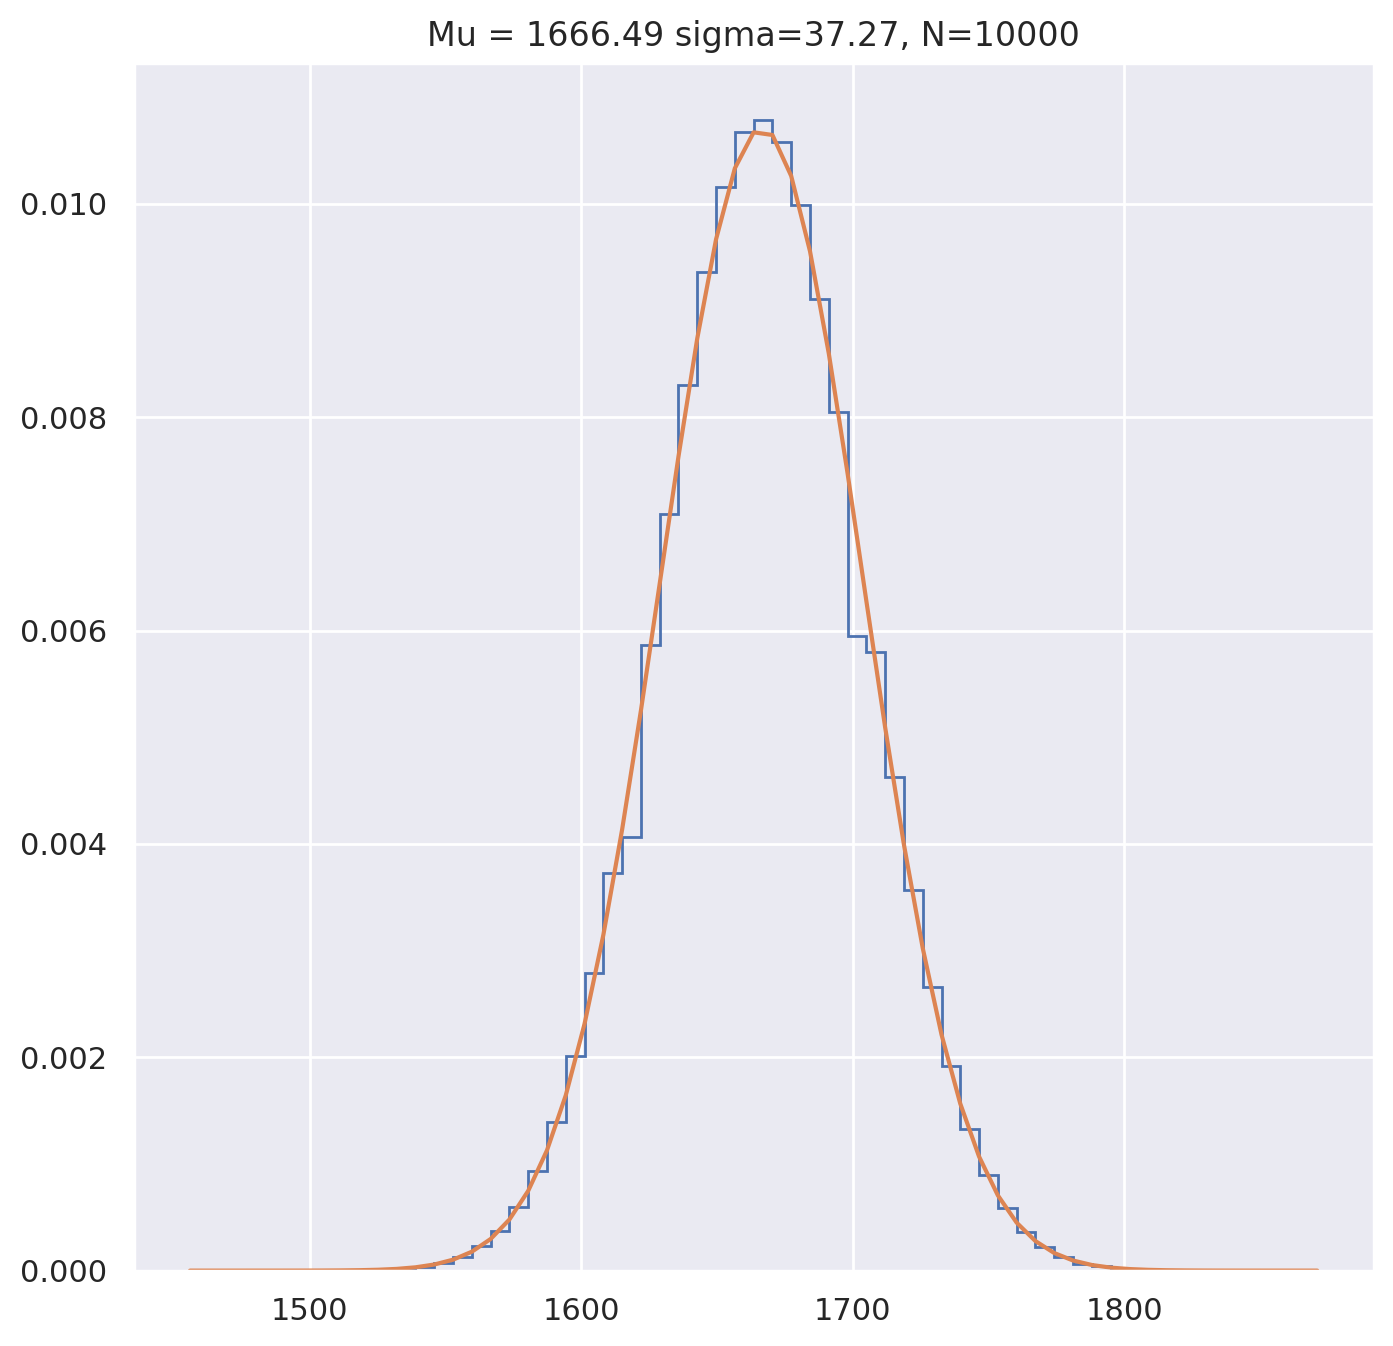

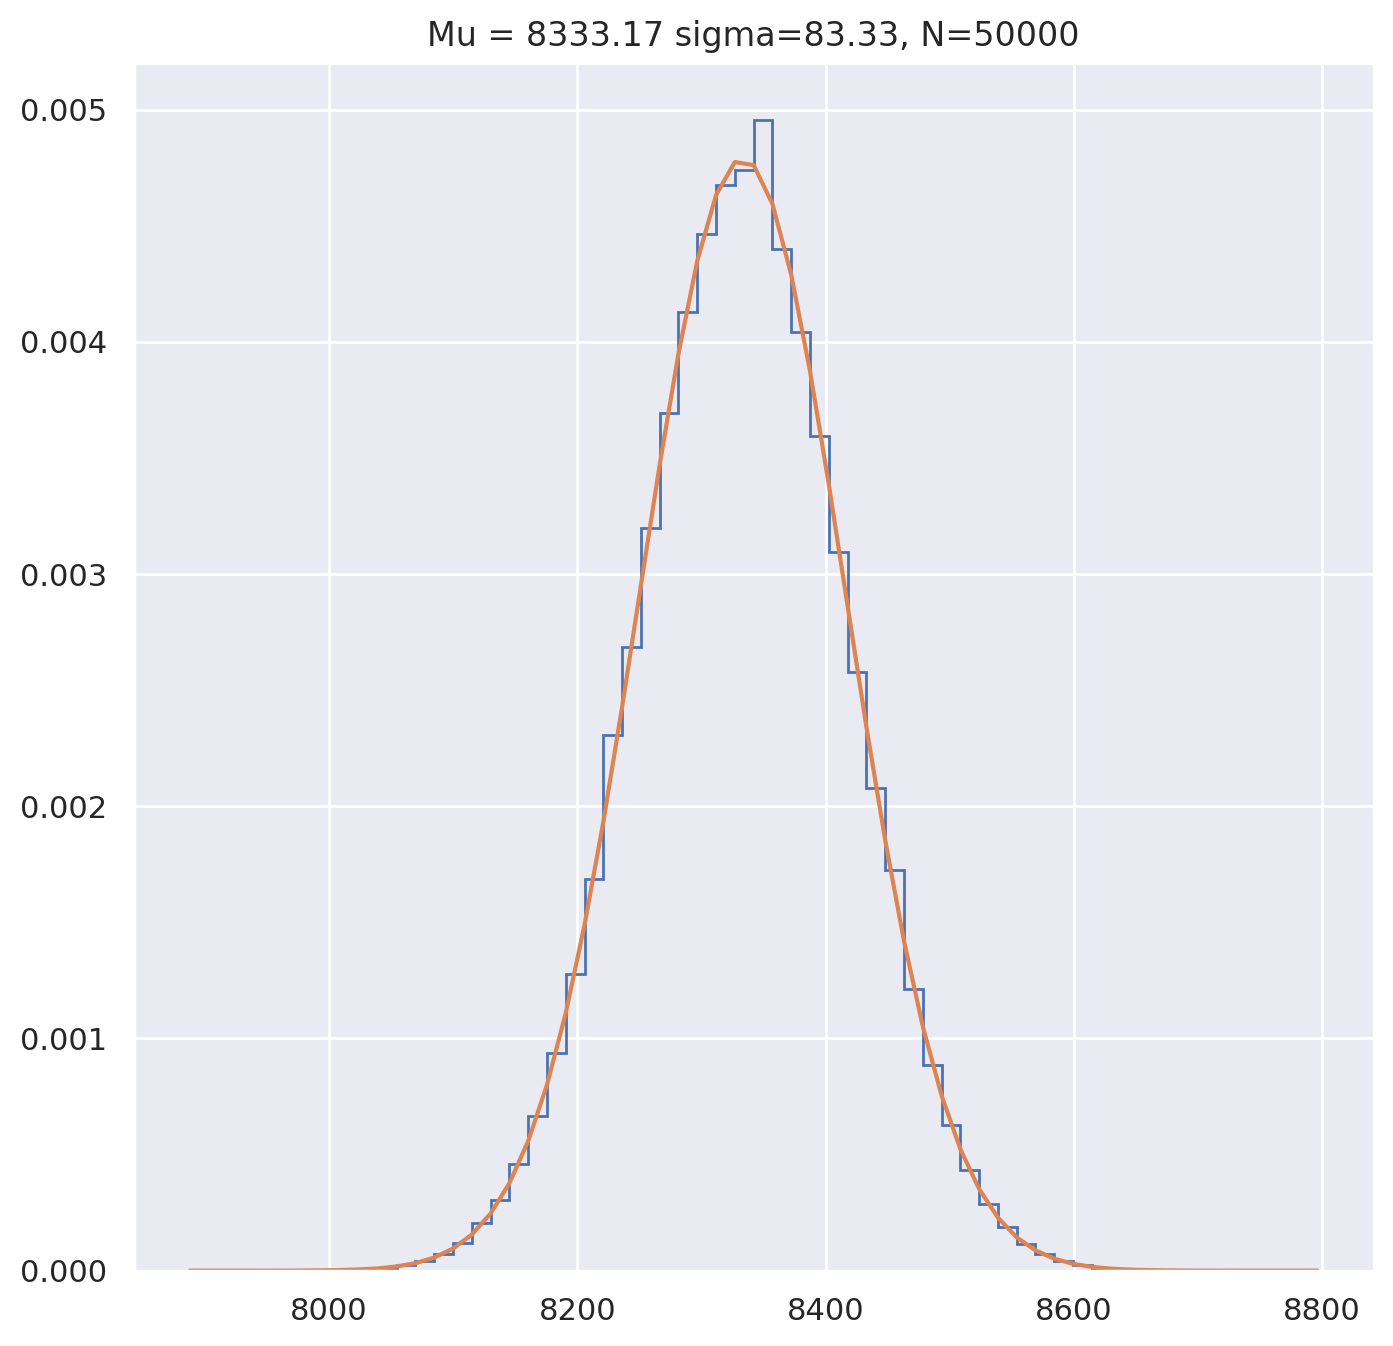

In [2]:
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

sns.set_theme()

def plot_and_fit(data, N):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
    _, bins, _ = ax.hist(data, bins=60, histtype="step", density=1)
    mu, sigma = stats.norm.fit(data)
    ax.set_title(f"Mu = {mu:.2f} sigma={sigma:.2f}, N={N}")
    best_fit = stats.norm.pdf(bins, mu, sigma)
    ax.plot(bins, best_fit)
    plt.show()

plot_and_fit(recon(ER10K), ER10K.shape[0])
plot_and_fit(recon(ER50K), ER50K.shape[0])

### Discussion of Results (4.1)

The results seem to agree with the predicted number of connections expected from an Erdos-Renyi network.

---


## Problem 4.2

Create  a  Small  World  Network  with  N  =  1000  nodes.  Initially  each  node  will  have  exactly  k=15 connections, i.e. there will be a total of 15x1000=15000 connections. Start redistributing the connections with probability p = 0.20. Make the plot of the distribution of k, P (k), as a function of k.The results should be an average of 1000 simulations.

### Solution

For this assignment, a `c++` program was created. The program starts by creating a ring lattice[[1]](https://runestone.academy/runestone/books/published/complex/SmallWorldGraphs/RingLattice.html), where each node is connected with its $k/2$ neighbors on its "left" and "right". The process is facilitated through the use of an adjacency matrix, where the index represents the Node and the values of the array are its connections.

For this exercise a k value of 16 was chosen instead of 15, as the ring lattice requires an even number of connections.

The `c++` program can be found in the attached files under `SmallWorld` and on [github](https://gist.github.com/iakovts/36d7e0d05dd0585fba26970f9b80d3a9).

Each node on the network has a 20% chance of being rewired. The rewiring function is presented and discussed below:

```c++
void SmallWorld::rewire() {
  for (int i = 0; i < N; i++) {
    for (auto &conn : adj_mat[i]) {
      if (change_maybe()) {
        int tmp_new = 0;
        int tmp_old = conn;
        // do look for new connections while avoiding
        // self loops and already existing connections
        do {
          tmp_new = uni_distrib(rng);
        } while (search_vec(adj_mat[i], tmp_new) || i == tmp_new);

        // Change connection of node and remove
        // current node from list of connections
        // from the old node.
        conn = tmp_new;
        adj_mat[tmp_new].push_back(i);
        Vec<int> &n_old = adj_mat[tmp_old];
        n_old.erase(std::remove(n_old.begin(), n_old.end(), i), n_old.end());
      }
    }
  }
}
```
For each connection of a given node, there is a 20% chance of it being rewired. When `change_maybe()==1`, a new temporary value (connection) is generated until it's not the value of the node itself, or an already existing connection. Then, the index of the current node is added to the array of connections of the "connecting" node, while it's also being removed from array of connections of the "old" connecting node.

Finally, in a similar manner as in problem 4.1, the aggregated results for a 1000 simulations are stored in a `txt` file.

Results and graphs are presented below.

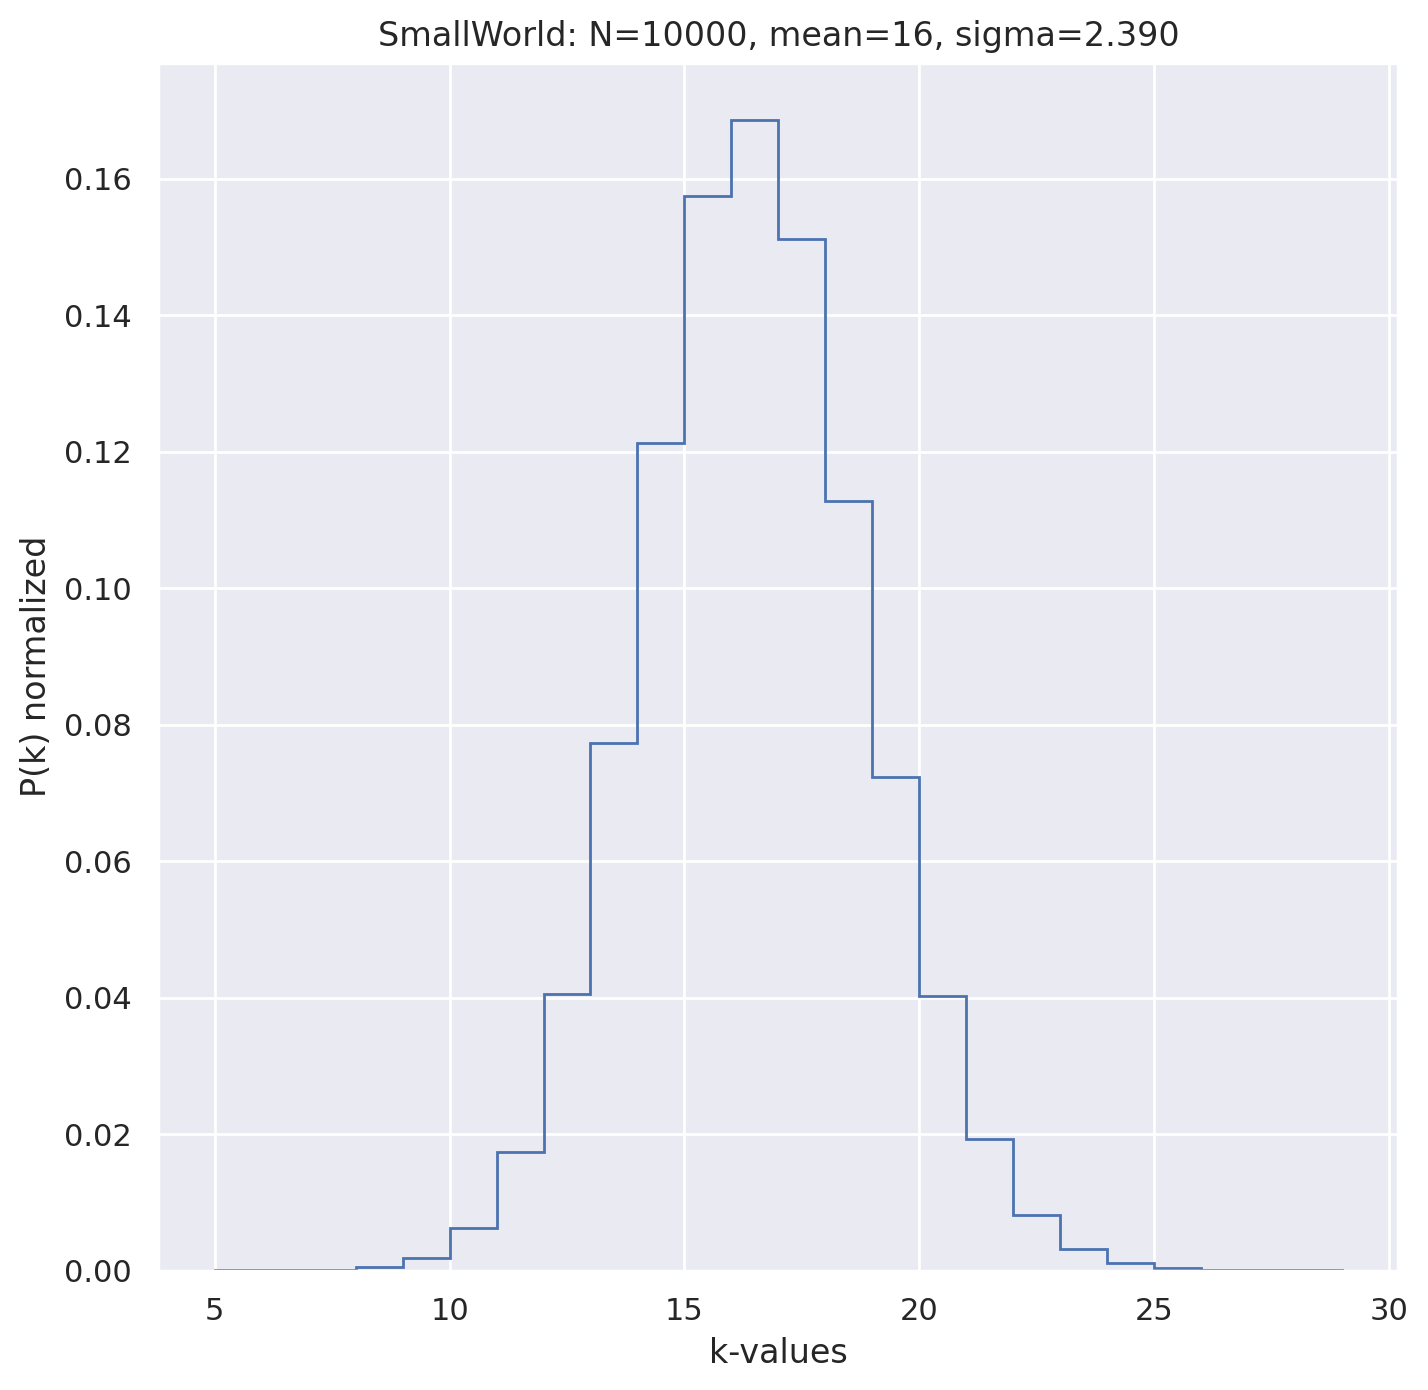

In [3]:
SW = np.loadtxt("SmallWorld.txt", dtype=np.int64)
re_sw = recon(SW)

mean_sw = np.mean(re_sw)
std_sw = np.std(re_sw)

fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
ax.set_xlabel("k-values")
ax.set_ylabel("P(k) normalized")
ax.set_title(f"SmallWorld: N=10000, mean={int(mean_sw)}, sigma={std_sw:.3f}")

ax.hist(re_sw, bins=np.unique(re_sw), histtype="step", density=True)
plt.show()


### Discussion of results (problem 4.2)

The results agree with the predicted value of mean connections which should be exactly 16, as each Node starts with 16 connections which are then only rewired and not created or destroyed. 

---

## Problem 4.3

Create  a  power  law  network  (scale-free network) with N = 10000 nodes and γ=3.  Assign a random number of k connections for each node with probability P(k)=$k^{-\gamma}$. Make the graph of the distribution of k, P (k), as a function of k. Find the value of γ exactly from the simulation. Do the same for γ = 2.0 and 2.5. The results should be an average of 1000 simulations


### Solution

For this assigment, another `c++` program was created. The program assigns a random number of connections per node from a discrete distribution following the rule that $P(k)=k^{-\gamma}$. 

The program can be found in the attached files or on [github](https://gist.github.com/iakovts/1589bac7bc38c01b797e0eda8b3262a0).

The processing of the results was done using the following python script, where the data are converted to log10 base, and a least squares regression is performed to find the γ value for each dataset.

Results and graphs are presented below:

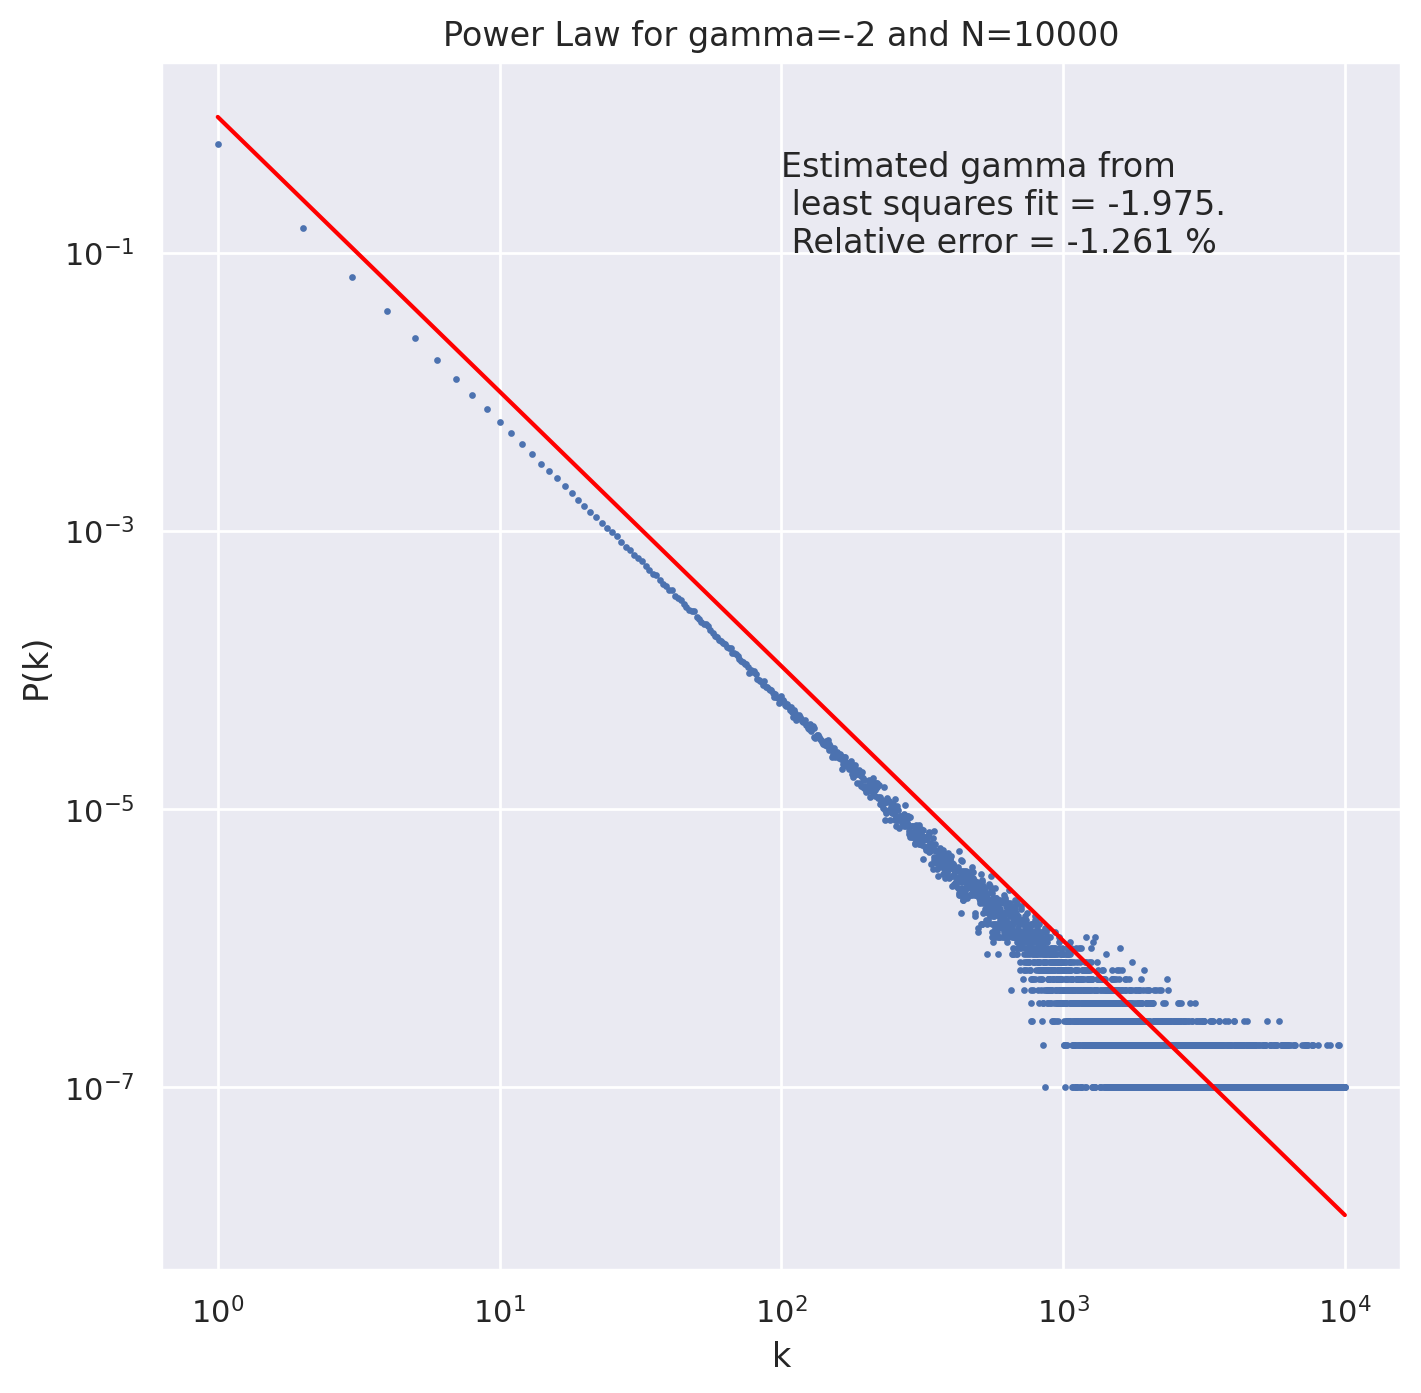

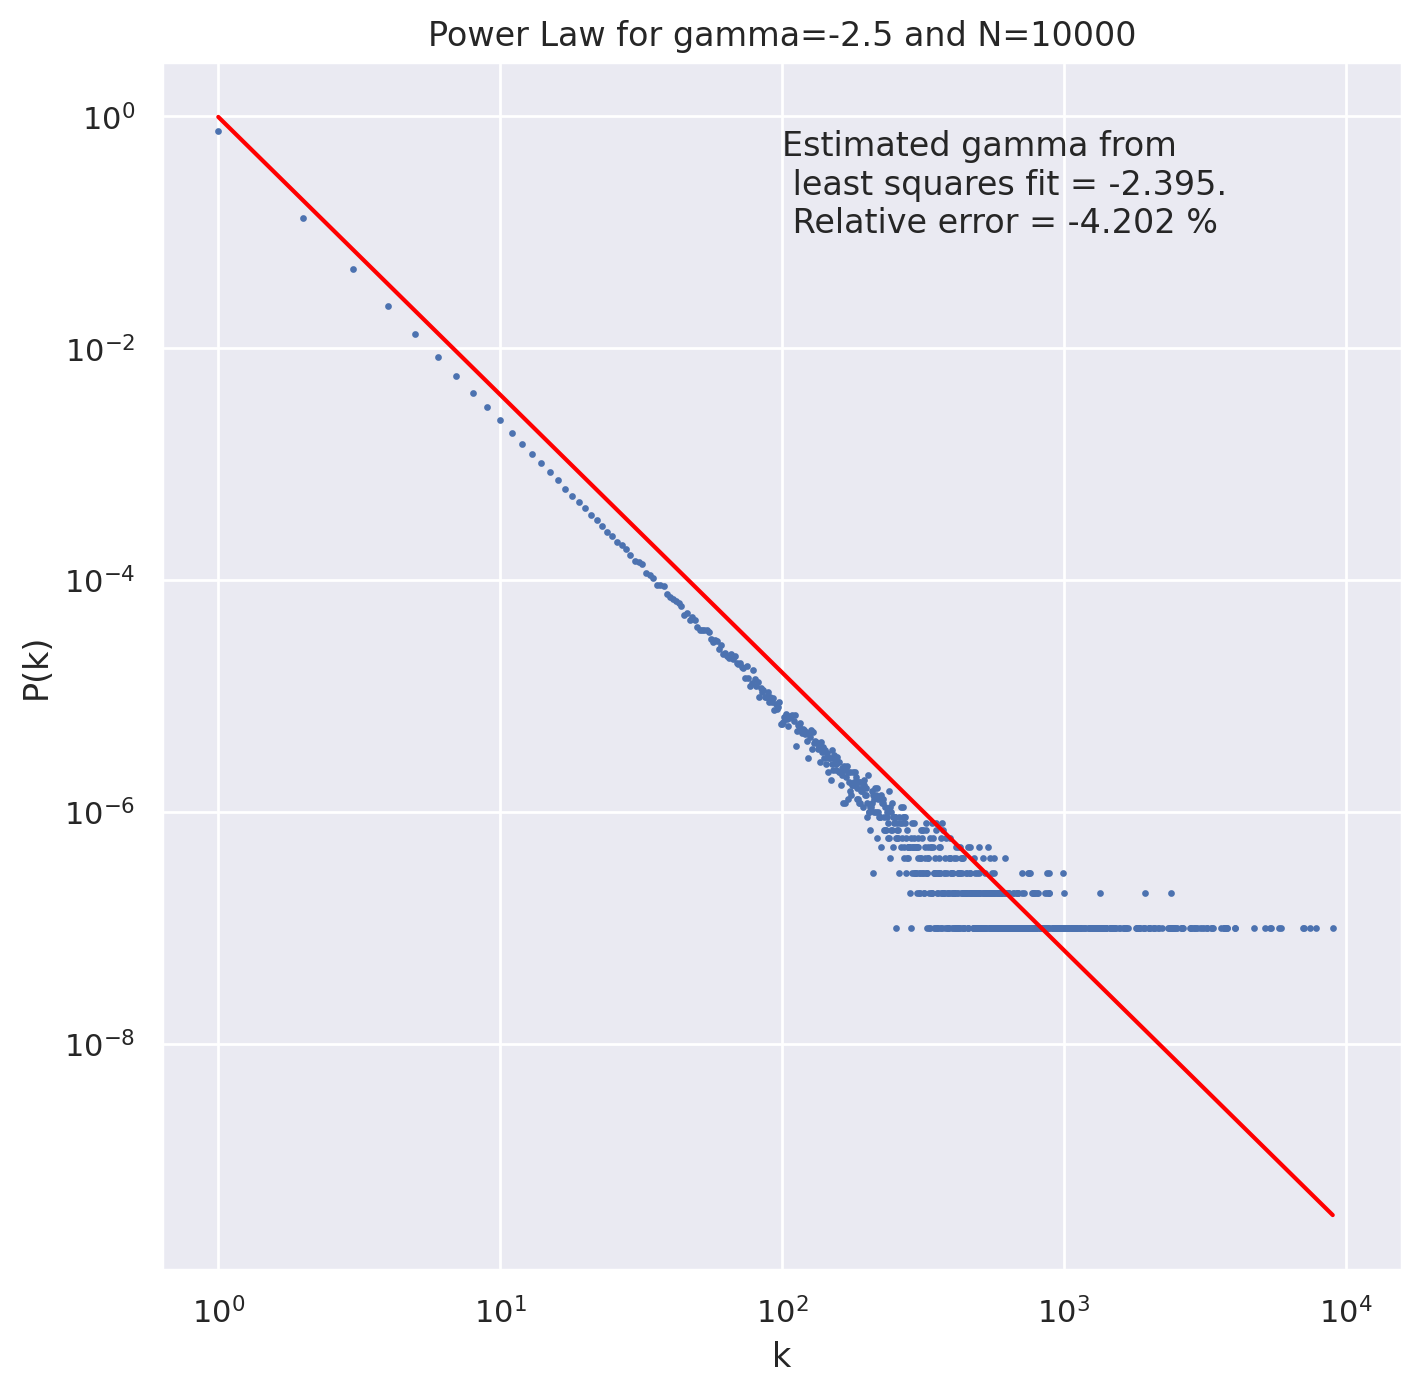

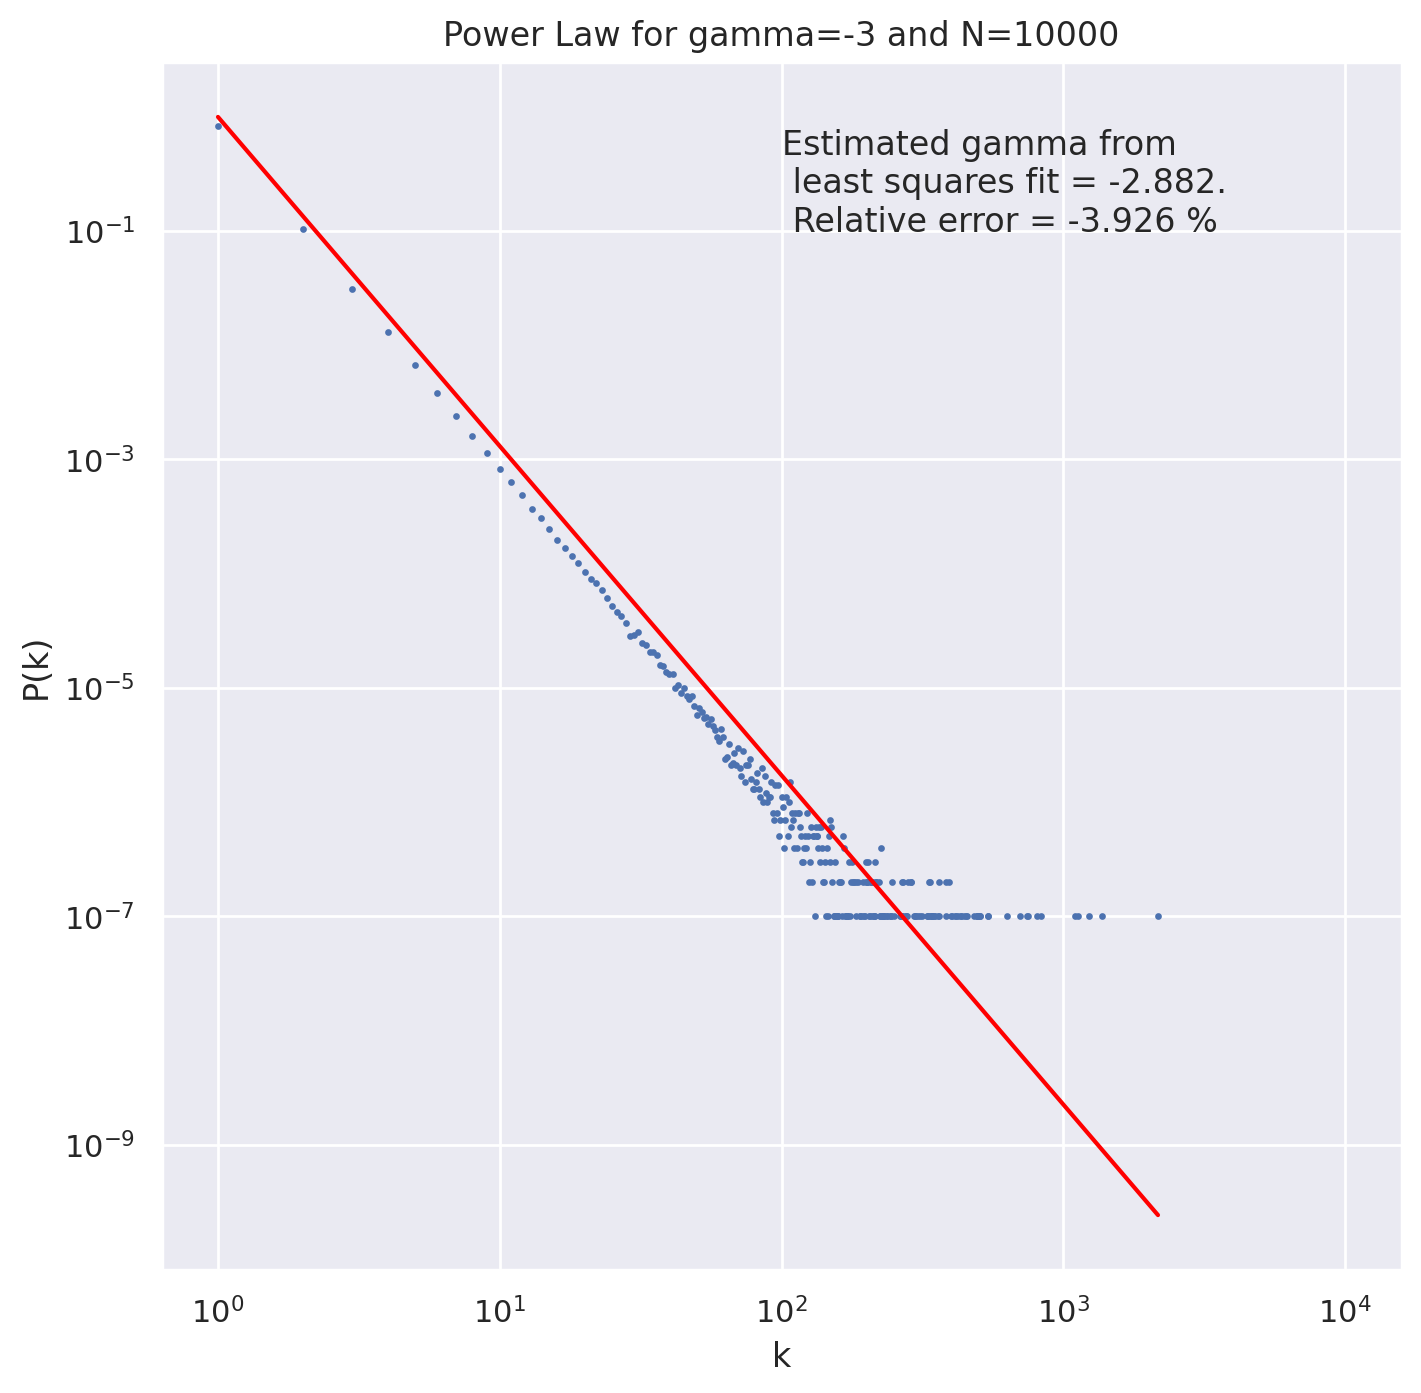

In [7]:

class ProcessPL:
    def __init__(self, data, gamma):
        self.data = data
        self.gamma = gamma
        self.slope = 0

    def least_square_fit(self):
        # Drop Node=0 and Node=N
        data = self.data[1:-1] 
        N = data.shape[0]
        k_vals = np.arange(1, N+1, 1)
        k_vals = k_vals[data != 0]
        data10 = np.log10(data[data != 0])
        k10 = np.log10(k_vals)
        #N = k10.shape[0]

        self.slope = (
            N * np.sum(data10 * k10) - np.sum(data10) * np.sum(k10)
        ) / (
            N * np.sum(k10 ** 2) - (np.sum(k10)) ** 2
        )

        interc = (np.sum(data10) - self.slope * np.sum(k10)) / N
        y = self.slope * k10 + interc

        return (10 ** k10, 10 ** y)
    
    def fit_and_plot(self):
        fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("k")
        ax.set_ylabel("P(k)")
        ax.scatter(np.arange(self.data.shape[0]), self.data, s=2)
        ax.plot(*self.least_square_fit(), color="red")
        ax.set_title(f"Power Law for gamma={self.gamma} and N=10000")
        ax.text(10 ** 2, 10 ** (-1),
                f"Estimated gamma from \n least squares fit"
                f" = {self.slope:.3f}. \n Relative error"
                f" = {(self.slope - self.gamma) / self.gamma * 100:.3f} %")
        plt.show()
        

gammas = [-2, -2.5, -3]

# Create a dictionary for all gammas and stores their values divided by number of runs * Nodes
PL = {
    gamma: np.loadtxt(f"PowerLaw{gamma}.txt", dtype=np.int64) / (1000 * 10000)
    for gamma in gammas
}

for gamma in gammas:
    Processed = ProcessPL(PL[gamma], gamma)
    Processed.fit_and_plot()

### Discussion of results (problem 4.3)

The simulation results for γ-values deviate from the given value of $\gamma$, but only by around 10%. Perhaps a gamma distribution could be fitted which would produce better estimates for the $\gamma$ value, instead of a Least Squares fit.

## Appendix

Python sample code for Erdos-Renyi network.
```python
import numpy as np
import seaborn

from dataclasses import dataclass
from matplotlib import pyplot as plt 
from scipy import stats


rng = np.random.default_rng(4385)

class Network:
    def __init__(self, N_nodes):
        self.N = N_nodes
        self.prob = None
        self.nodes = [Node() for i in range(N_nodes)]
    
    def connect(self):
        for node in self.nodes:
            self.prob = rng.choice([0, 1], size=self.N, p=[5/6, 1/6])
            for i in range(self.N):
                if self.prob[i] != 0:
                    if node != self.nodes[i]:
                        node.k += 1


@dataclass(eq=False)
class Node:
    k: int = 0

        

nw = Network(10000)
nw.connect()

ks = [node.k for node in nw.nodes]
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
_, bins, _ = ax.hist(ks, bins=20, histtype="step", density=1)
mu, sigma = stats.norm.fit(ks)
ax.set_title(f"Mu = {mu:.2f} sigma={sigma:.2f}")
best_fit = stats.norm.pdf(bins, mu, sigma)
ax.plot(bins, best_fit)

plt.show()
```